---
title: Diagramming
---

# Diagramming: Visualizing Schema Structure

Schema diagrams are essential tools for understanding and designing DataJoint pipelines.
They provide a visual representation of tables and their dependencies, making complex workflows comprehensible at a glance.

Building on the [Foreign Keys](030-foreign-keys.md) chapter—which covered how foreign key placement affects relationship structure—this chapter focuses on how to **read and interpret** the visual representation of these relationships.

As introduced in [Relational Workflows](../20-concepts/05-workflows.md), DataJoint schemas form **Directed Acyclic Graphs (DAGs)** where:

- **Nodes** represent tables (workflow steps)
- **Edges** represent foreign key dependencies
- **Direction** flows from parent (referenced) to child (referencing) tables

This DAG structure embodies a core principle of the Relational Workflow Model: **the schema is an executable specification**.
Tables at the top are independent entities; tables below depend on tables above them.
Reading the diagram top-to-bottom reveals the workflow execution order.

```{admonition} Learning Objectives
:class: note

By the end of this chapter, you will:
- Understand the three line styles and their semantic meanings
- Identify relationship types from diagram structure
- Recognize what diagrams show and don't show
- Use diagram operations to explore large schemas
- Compare DataJoint notation with traditional ER diagrams
```

# Quick Reference

| Line Style | Appearance | Relationship | Child's Primary Key | Cardinality |
|------------|------------|--------------|---------------------|-------------|
| **Thick Solid** | ━━━ | Extension | Parent PK only | One-to-one |
| **Thin Solid** | ─── | Containment | Parent PK + own field(s) | One-to-many |
| **Dashed** | ┄┄┄ | Reference | Own independent PK | One-to-many |

```{card} Key Principle
**Solid lines** mean the parent's identity becomes part of the child's identity.
**Dashed lines** mean the child maintains independent identity.
```

**Visual Indicators:**
- **Underlined table name**: Independent entity introducing a new schema dimension
- **Non-underlined name**: Dependent entity whose identity derives from parent(s)
- **Orange dots**: Renamed foreign keys (via `.proj()`)
- **Table colors**: Green (Manual), Blue (Imported), Red (Computed), Gray (Lookup)

# Setup

First, we import DataJoint and create a schema for our examples:

In [1]:
# create a new tutorial schema
import datajoint as dj
schema = dj.Schema('diagrams_tutorial')

[2025-12-18 16:08:53,551][INFO]: DataJoint 0.14.6 connected to dev@db:3306


# The Three Line Styles

Line styles convey the **semantic relationship** between parent and child tables.
The choice is determined by where the foreign key appears in the child's definition.

## Thick Solid Line: Extension (One-to-One)

The foreign key **is** the entire primary key of the child table.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    customer_name : varchar(60)
    """

@schema
class CustomerPreferences(dj.Manual):
    definition = """
    -> Customer                   # This IS the entire primary key
    ---
    theme : varchar(20)
    notifications : enum('on', 'off')
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE customer (
    customer_id INT UNSIGNED NOT NULL,
    customer_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (customer_id)
);

CREATE TABLE customer_preferences (
    customer_id INT UNSIGNED NOT NULL,
    theme VARCHAR(20) NOT NULL,
    notifications ENUM('on', 'off') NOT NULL,
    PRIMARY KEY (customer_id),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);
```
````
`````

**Semantics**: The child *extends* or *specializes* the parent.
They share the same identity—at most one child exists for each parent.

**Use cases**: Workflow sequences (Order → Shipment → Delivery), optional extensions (Customer → CustomerPreferences), modular data organization.

**In diagrams**: Notice that `CustomerPreferences` is **not underlined**—it doesn't introduce a new dimension.

In [2]:
# Define tables for thick solid line example
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    customer_name : varchar(60)
    """

@schema
class CustomerPreferences(dj.Manual):
    definition = """
    -> Customer                   # This IS the entire primary key
    ---
    theme : varchar(20)
    notifications : enum('on', 'off')
    """

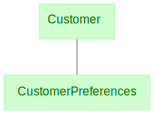

In [3]:
# View the diagram - notice the thick solid line
dj.Diagram(Customer) + dj.Diagram(CustomerPreferences)

## Thin Solid Line: Containment (One-to-Many)

The foreign key is **part of** (but not all of) the child's primary key.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Customer(dj.Manual):
    definition = """
    customer_id : int unsigned
    ---
    customer_name : varchar(60)
    """

@schema
class Account(dj.Manual):
    definition = """
    -> Customer                   # Part of primary key
    account_num : int unsigned    # Additional PK component
    ---
    balance : decimal(10,2)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE customer (
    customer_id INT UNSIGNED NOT NULL,
    customer_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (customer_id)
);

CREATE TABLE account (
    customer_id INT UNSIGNED NOT NULL,
    account_num INT UNSIGNED NOT NULL,
    balance DECIMAL(10,2) NOT NULL,
    PRIMARY KEY (customer_id, account_num),
    FOREIGN KEY (customer_id) REFERENCES customer(customer_id)
);
```
````
`````

**Semantics**: The child *belongs to* or *is contained within* the parent.
Multiple children can exist for each parent, each identified within the parent's context.

**Use cases**: Hierarchies (Study → Subject → Session), ownership (Customer → Account), containment (Order → OrderItem).

**In diagrams**: `Account` is **underlined** because `account_num` introduces a new dimension.

In [4]:
# Define tables for thin solid line example
@schema
class Account(dj.Manual):
    definition = """
    -> Customer                   # Part of primary key
    account_num : int unsigned    # Additional PK component
    ---
    balance : decimal(10,2)
    """

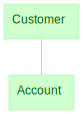

In [5]:
# View the diagram - notice the thin solid line
dj.Diagram(Customer) + dj.Diagram(Account)

## Dashed Line: Reference (One-to-Many)

The foreign key is a **secondary attribute** (below the `---` line).

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Department(dj.Manual):
    definition = """
    dept_id : int unsigned
    ---
    dept_name : varchar(60)
    """

@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int unsigned    # Own independent PK
    ---
    -> Department                 # Secondary attribute
    employee_name : varchar(60)
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE department (
    dept_id INT UNSIGNED NOT NULL,
    dept_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (dept_id)
);

CREATE TABLE employee (
    employee_id INT UNSIGNED NOT NULL,
    dept_id INT UNSIGNED NOT NULL,
    employee_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (employee_id),
    FOREIGN KEY (dept_id) REFERENCES department(dept_id)
);
```
````
`````

**Semantics**: The child *references* or *associates with* the parent but maintains independent identity.
The parent is just one attribute describing the child.

**Use cases**: Loose associations (Product → Category), references that might change (Employee → Department), when child has independent identity.

In [6]:
# Define tables for dashed line example
@schema
class Department(dj.Manual):
    definition = """
    dept_id : int unsigned
    ---
    dept_name : varchar(60)
    """

@schema
class Employee(dj.Manual):
    definition = """
    employee_id : int unsigned    # Own independent PK
    ---
    -> Department                 # Secondary attribute
    employee_name : varchar(60)
    """

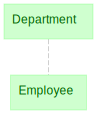

In [7]:
# View the diagram - notice the dashed line
dj.Diagram(Department) + dj.Diagram(Employee)

# What Diagrams Show and Don't Show

Understanding the limitations of diagram notation is crucial for accurate schema interpretation.

```{admonition} Diagrams Do NOT Reflect Foreign Key Modifiers
:class: warning

The `nullable` and `unique` modifiers on foreign keys are **not visible** in diagrams.

- A **dashed line** could represent:
  - A required one-to-many relationship (default)
  - An optional one-to-many relationship (`nullable`)
  - A required one-to-one relationship (`unique`)
  - An optional one-to-one relationship (`nullable, unique`)

**Always check the table definition** to determine if modifiers are applied.
```

## Clearly Indicated in Diagrams

| Feature | How It's Shown |
|---------|----------------|
| Foreign key in primary key | Solid line (thick or thin) |
| Foreign key as secondary attribute | Dashed line |
| One-to-one via shared identity | Thick solid line |
| One-to-many via containment | Thin solid line |
| Independent entity (new dimension) | Underlined table name |
| Dependent entity (shared dimension) | Non-underlined table name |
| Table tier | Colors (Green/Blue/Red/Gray) |
| Many-to-many patterns | Converging solid lines into association table |
| Renamed foreign keys | Orange dots on connection |

## NOT Visible in Diagrams

| Feature | Must Check Table Definition |
|---------|----------------------------|
| `nullable` foreign keys | Definition shows `-> [nullable] Parent` |
| `unique` foreign keys | Definition shows `-> [unique] Parent` |
| Combined modifiers | Definition shows `-> [nullable, unique] Parent` |
| Secondary unique indexes | Definition shows `unique index(...)` |
| CHECK constraints | Definition shows constraint |
| Attribute names and types | Hover tooltip or inspect definition |
| Default values | Definition shows `= value` |

## Example: Hidden Uniqueness

Consider these two schemas—they produce **identical diagrams**:

`````{tab-set}
````{tab-item} Many Spots per Employee
```python
@schema
class ParkingSpot(dj.Manual):
    definition = """
    spot_id : int unsigned
    ---
    -> Employee                   # many spots per employee allowed
    location : varchar(30)
    """
```
````
````{tab-item} One Spot per Employee
```python
@schema
class ParkingSpot(dj.Manual):
    definition = """
    spot_id : int unsigned
    ---
    -> [unique] Employee          # only one spot per employee
    location : varchar(30)
    """
```
````
`````

Both show a dashed line from `ParkingSpot` to `Employee`.
Only by examining the definition can you see the `unique` constraint.

```{admonition} Interactive Tip
:class: tip

In Jupyter notebooks, **hover over table nodes** in the diagram to see the complete table definition, including any modifiers and constraints.
```

# Association Tables and Many-to-Many

Many-to-many relationships appear as tables with **converging foreign keys**—multiple solid lines pointing into a single table.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned
    ---
    student_name : varchar(60)
    """

@schema
class Course(dj.Manual):
    definition = """
    course_code : char(8)
    ---
    course_title : varchar(100)
    """

@schema
class Enrollment(dj.Manual):
    definition = """
    -> Student
    -> Course
    ---
    grade : enum('A', 'B', 'C', 'D', 'F')
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE student (
    student_id INT UNSIGNED NOT NULL,
    student_name VARCHAR(60) NOT NULL,
    PRIMARY KEY (student_id)
);

CREATE TABLE course (
    course_code CHAR(8) NOT NULL,
    course_title VARCHAR(100) NOT NULL,
    PRIMARY KEY (course_code)
);

CREATE TABLE enrollment (
    student_id INT UNSIGNED NOT NULL,
    course_code CHAR(8) NOT NULL,
    grade ENUM('A', 'B', 'C', 'D', 'F') NOT NULL,
    PRIMARY KEY (student_id, course_code),
    FOREIGN KEY (student_id) REFERENCES student(student_id),
    FOREIGN KEY (course_code) REFERENCES course(course_code)
);
```
````
`````

**Reading the diagram:**
- `Student` and `Course` are independent entities (underlined, at top)
- `Enrollment` has two thin solid lines converging into it
- Its primary key is `(student_id, course_code)`—the combination of both parents
- This creates a many-to-many: each student can take multiple courses, each course can have multiple students

In [8]:
# Define tables for many-to-many example
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned
    ---
    student_name : varchar(60)
    """

@schema
class Course(dj.Manual):
    definition = """
    course_code : char(8)
    ---
    course_title : varchar(100)
    """

@schema
class Enrollment(dj.Manual):
    definition = """
    -> Student
    -> Course
    ---
    grade : enum('A', 'B', 'C', 'D', 'F')
    """

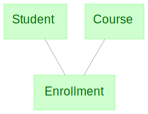

In [9]:
# View the many-to-many diagram
dj.Diagram(Enrollment) - 1

# Renamed Foreign Keys and Orange Dots

When you reference the same parent table multiple times, or need semantic clarity, use `.proj()` to rename foreign key attributes.

`````{tab-set}
````{tab-item} DataJoint
:sync: datajoint
```python
@schema
class Neuron(dj.Manual):
    definition = """
    neuron_id : int unsigned
    ---
    neuron_type : enum('excitatory', 'inhibitory')
    """

@schema
class Synapse(dj.Manual):
    definition = """
    synapse_id : int unsigned
    ---
    -> Neuron.proj(presynaptic='neuron_id')
    -> Neuron.proj(postsynaptic='neuron_id')
    strength : float
    """
```
````
````{tab-item} SQL
:sync: sql
```sql
CREATE TABLE neuron (
    neuron_id INT UNSIGNED NOT NULL,
    neuron_type ENUM('excitatory', 'inhibitory') NOT NULL,
    PRIMARY KEY (neuron_id)
);

CREATE TABLE synapse (
    synapse_id INT UNSIGNED NOT NULL,
    presynaptic INT UNSIGNED NOT NULL,
    postsynaptic INT UNSIGNED NOT NULL,
    strength FLOAT NOT NULL,
    PRIMARY KEY (synapse_id),
    FOREIGN KEY (presynaptic) REFERENCES neuron(neuron_id),
    FOREIGN KEY (postsynaptic) REFERENCES neuron(neuron_id)
);
```
````
`````

**Orange dots** appear between `Neuron` and `Synapse`, indicating:
- A projection has renamed the foreign key attributes
- Two distinct foreign keys connect the same pair of tables
- `presynaptic` and `postsynaptic` both reference `Neuron.neuron_id`

In interactive Jupyter notebooks, hovering over orange dots reveals the projection expression.

**Common patterns using renamed foreign keys:**
- Neural networks: presynaptic and postsynaptic neurons
- Organizational hierarchies: employee and manager
- Transportation: origin and destination airports

In [10]:
# Define tables for renamed foreign key example
@schema
class Neuron(dj.Manual):
    definition = """
    neuron_id : int unsigned
    ---
    neuron_type : enum('excitatory', 'inhibitory')
    """

@schema
class Synapse(dj.Manual):
    definition = """
    synapse_id : int unsigned
    ---
    -> Neuron.proj(presynaptic='neuron_id')
    -> Neuron.proj(postsynaptic='neuron_id')
    strength : float
    """

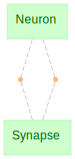

In [11]:
# View the diagram - notice the orange dots indicating renamed foreign keys
dj.Diagram(Neuron) + dj.Diagram(Synapse)

# Diagram Operations

DataJoint provides operators to filter and combine diagrams for exploring large schemas:

```python
# Show entire schema
dj.Diagram(schema)

# Show specific tables
dj.Diagram(Table1) + dj.Diagram(Table2)

# Show table and N levels of upstream dependencies
dj.Diagram(Table) - N

# Show table and N levels of downstream dependents
dj.Diagram(Table) + N

# Combine operations
(dj.Diagram(Table1) - 2) + (dj.Diagram(Table2) + 1)

# Intersection: show only common nodes between two diagrams
dj.Diagram(Table1) * dj.Diagram(Table2)
```

## Finding Paths Between Tables

The intersection operator `*` is particularly useful for finding connection paths between two tables in a large schema.
By expanding one table downstream and another upstream, then taking the intersection, you reveal only the tables that form the path(s) between them:

```python
# Find all paths connecting table1 to table2 (where table2 is downstream from table1)
(dj.Diagram(table1) + 100) * (dj.Diagram(table2) - 100)
```

This works because:
- `dj.Diagram(table1) + 100` includes table1 and up to 100 levels of downstream dependents
- `dj.Diagram(table2) - 100` includes table2 and up to 100 levels of upstream dependencies
- The intersection `*` shows only tables that appear in **both** diagrams—the connecting path(s)

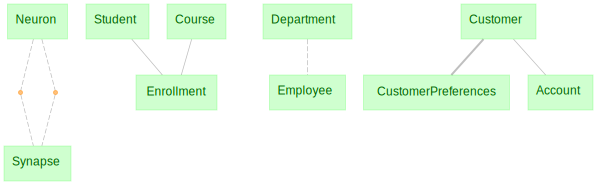

In [12]:
# View the entire schema we've built
dj.Diagram(schema)

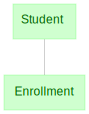

In [13]:
# Find the path from Student to Enrollment using intersection
# Expand Student downstream and Enrollment upstream, then intersect
(dj.Diagram(Student) + 100) * (dj.Diagram(Enrollment) - 100)

# Diagrams and Queries

The diagram structure directly informs query patterns.

**Solid line paths enable direct joins:**
```python
# If A → B → C are connected by solid lines:
A * C  # Valid—primary keys cascade through solid lines
```

**Dashed lines require intermediate tables:**
```python
# If A ---> B (dashed), B → C (solid):
A * B * C  # Must include B to connect A and C
```

This is why solid lines are preferred when the relationship supports it—they simplify queries by allowing you to join non-adjacent tables directly.

# Comparison to Other Notations

DataJoint's notation differs significantly from traditional database diagramming:

| Feature | Chen's ER | Crow's Foot | DataJoint |
|---------|-----------|-------------|-----------|
| **Cardinality** | Numbers near entities | Symbols at line ends | Line thickness/style |
| **Direction** | No inherent direction | No inherent direction | Top-to-bottom (DAG) |
| **Cycles allowed** | Yes | Yes | No |
| **Entity vs. relationship** | Distinct symbols | Not distinguished | Not distinguished |
| **Primary key cascade** | Not shown | Not shown | Solid lines show this |
| **Identity sharing** | Not indicated | Not indicated | Thick solid line |

**Why DataJoint differs:**

1. **DAG structure**: No cycles means schemas are readable as workflows (top-to-bottom execution order)
2. **Line style semantics**: Immediately reveals relationship type without reading labels
3. **Primary key cascade visibility**: Solid lines show which tables can be joined directly
4. **Unified entity treatment**: No artificial distinction between "entities" and "relationships"

```{seealso}
The [Relational Workflows](../20-concepts/05-workflows.md) chapter covers the three database paradigms in depth, including how DataJoint's workflow-centric approach compares to Codd's mathematical model and Chen's Entity-Relationship model.
```

# Best Practices

## Reading Diagrams

1. **Start at the top**: Identify independent entities (underlined)
2. **Follow solid lines**: Trace primary key cascades downward
3. **Spot convergence patterns**: Multiple lines into a table indicate associations
4. **Check line thickness**: Thick = one-to-one, Thin = one-to-many containment
5. **Note dashed lines**: These don't cascade identity
6. **Check definitions**: For `nullable`, `unique`, and other constraints not visible in diagrams

## Designing with Diagrams

1. **Choose solid lines when**:
   - Building hierarchies (Study → Subject → Session)
   - Creating workflow sequences (Order → Ship → Deliver)
   - You want direct joins across levels

2. **Choose dashed lines when**:
   - Child has independent identity from parent
   - Reference might change or is optional
   - You don't need primary key cascade

3. **Choose thick lines when**:
   - Extending entities with optional information
   - Modeling workflow steps (one output per input)
   - Creating true one-to-one relationships

## Interactive Tips

- **Hover over tables** to see complete definitions (works in Jupyter and SVG exports)
- **Hover over orange dots** to see projection expressions
- **Use `+` and `-` operators** to focus on specific parts of large schemas

# Summary

| Concept | Key Points |
|---------|------------|
| **Line Styles** | Thick solid (extension), thin solid (containment), dashed (reference) |
| **Underlined Names** | Indicate tables introducing new schema dimensions |
| **Orange Dots** | Indicate renamed foreign keys via `.proj()` |
| **Diagram Shows** | Foreign key placement, relationship structure, table tiers |
| **Diagram Doesn't Show** | `nullable`, `unique` modifiers, secondary indexes |

```{admonition} Key Principle
:class: tip

DataJoint diagrams show **structural relationships** based on where foreign keys appear in table definitions.
They do **not** show constraint modifiers (`nullable`, `unique`) that alter the cardinality of secondary foreign keys.

**Always check the table definition** for the complete picture.
```

```{admonition} Remember
:class: note

In DataJoint, diagrams and implementation are unified.
There's no separate design document that can drift out of sync—the diagram **is** generated from the actual schema.
```

```{admonition} Next Steps
:class: note

Now that you can read and interpret schema diagrams:
- **[Relationships](050-relationships.ipynb)** — Explore relationship patterns: one-to-one, one-to-many, many-to-many, hierarchies, and more
- **[Master-Part Tables](053-master-part.ipynb)** — Special pattern for composite entities
```

# Cleanup

Optionally drop the tutorial schema when done:

In [14]:
# drop the schema
schema.drop(force=True)